# Análisis Exploratorio de Datos (EDA) - GTFS Histórico Cleaned

## Objetivo
Realizar un análisis descriptivo y exploratorio del dataset de retrasos del metro NYC después de la transformación cleaned.
Este análisis permite entender las características principales de las variables y sus relaciones, especialmente con la variable objetivo (delay_seconds).

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os, sys, warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Setup completado")

✓ Setup completado


In [137]:
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))
from src.common.minio_client import download_df_parquet

access_key = os.getenv("MINIO_ACCESS_KEY")
secret_key = os.getenv("MINIO_SECRET_KEY")

if not access_key or not secret_key:
    raise ValueError("Las variables de entorno MINIO_ACCESS_KEY y MINIO_SECRET_KEY no están definidas")

# Descargar datos
START_DATE = "2025-01-01"
END_DATE = "2025-01-07"

dates = pd.date_range(start=START_DATE, end=END_DATE).strftime("%Y-%m-%d").tolist()
dfs = []

for SERVICE_DATE in dates:
    sched = download_df_parquet(access_key, secret_key, f"grupo5/cleaned/gtfs_clean_scheduled/date={SERVICE_DATE}/gtfs_scheduled_{SERVICE_DATE}.parquet")
    unsched = download_df_parquet(access_key, secret_key, f"grupo5/cleaned/gtfs_clean_unscheduled/date={SERVICE_DATE}/gtfs_unscheduled_{SERVICE_DATE}.parquet")
    sched['dataset_type'] = 'scheduled'
    unsched['dataset_type'] = 'unscheduled'
    dfs.extend([sched, unsched])

df_full = pd.concat(dfs, ignore_index=True)
split_info = df_full['dataset_type'].value_counts()

print(f"✓ Datos cargados: {len(df_full):,} registros")
print(f"  - Scheduled: {split_info.get('scheduled', 0):,}")
print(f"  - Unscheduled: {split_info.get('unscheduled', 0):,}")

✓ Datos cargados: 1,390,472 registros
  - Scheduled: 1,046,665
  - Unscheduled: 343,807


## Sección 1: Análisis General

In [138]:
print("="*70)
print("1.1 DIMENSIONES")
print("="*70)
print(f"Shape: {df_full.shape}")
print(f"Memoria: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

dtype_summary = pd.DataFrame({
    'Columna': df_full.columns,
    'Tipo': df_full.dtypes.values,
    'No Nulos': df_full.count().values,
    '% Nulos': (df_full.isnull().sum().values / len(df_full) * 100).round(2)
})
print("\n" + dtype_summary.to_string(index=False))

1.1 DIMENSIONES
Shape: (1390472, 33)
Memoria: 481.47 MB

                Columna    Tipo  No Nulos  % Nulos
               trip_uid  string   1390472     0.00
              match_key  string   1390472     0.00
               route_id  string   1046665    24.73
                stop_id  string   1390472     0.00
         is_unscheduled    bool   1390472     0.00
      scheduled_seconds float64   1046665    24.73
         actual_seconds float64   1374425     1.15
          delay_seconds float64   1030618    25.88
          delay_minutes float64   1030618    25.88
           service_date     str   1390472     0.00
                   hour   Int64   1390472     0.00
               hour_sin float64   1390472     0.00
               hour_cos float64   1390472     0.00
                    dow   Int64   1390472     0.00
             is_weekend   Int64   1390472     0.00
         scheduled_time     str   1046665    24.73
            actual_time     str   1374425     1.15
         lagged_delay_1 f

## Sección 2: Variable Objetivo (delay_seconds)


2.1 ESTADÍSTICAS DELAY_SECONDS
count    1.030618e+06
mean     8.270950e+01
std      2.944102e+02
min     -3.600000e+03
25%     -4.800000e+01
50%      2.300000e+01
75%      1.520000e+02
90%      3.580000e+02
95%      5.350000e+02
99%      1.085000e+03
max      8.996000e+03
Name: delay_seconds, dtype: float64


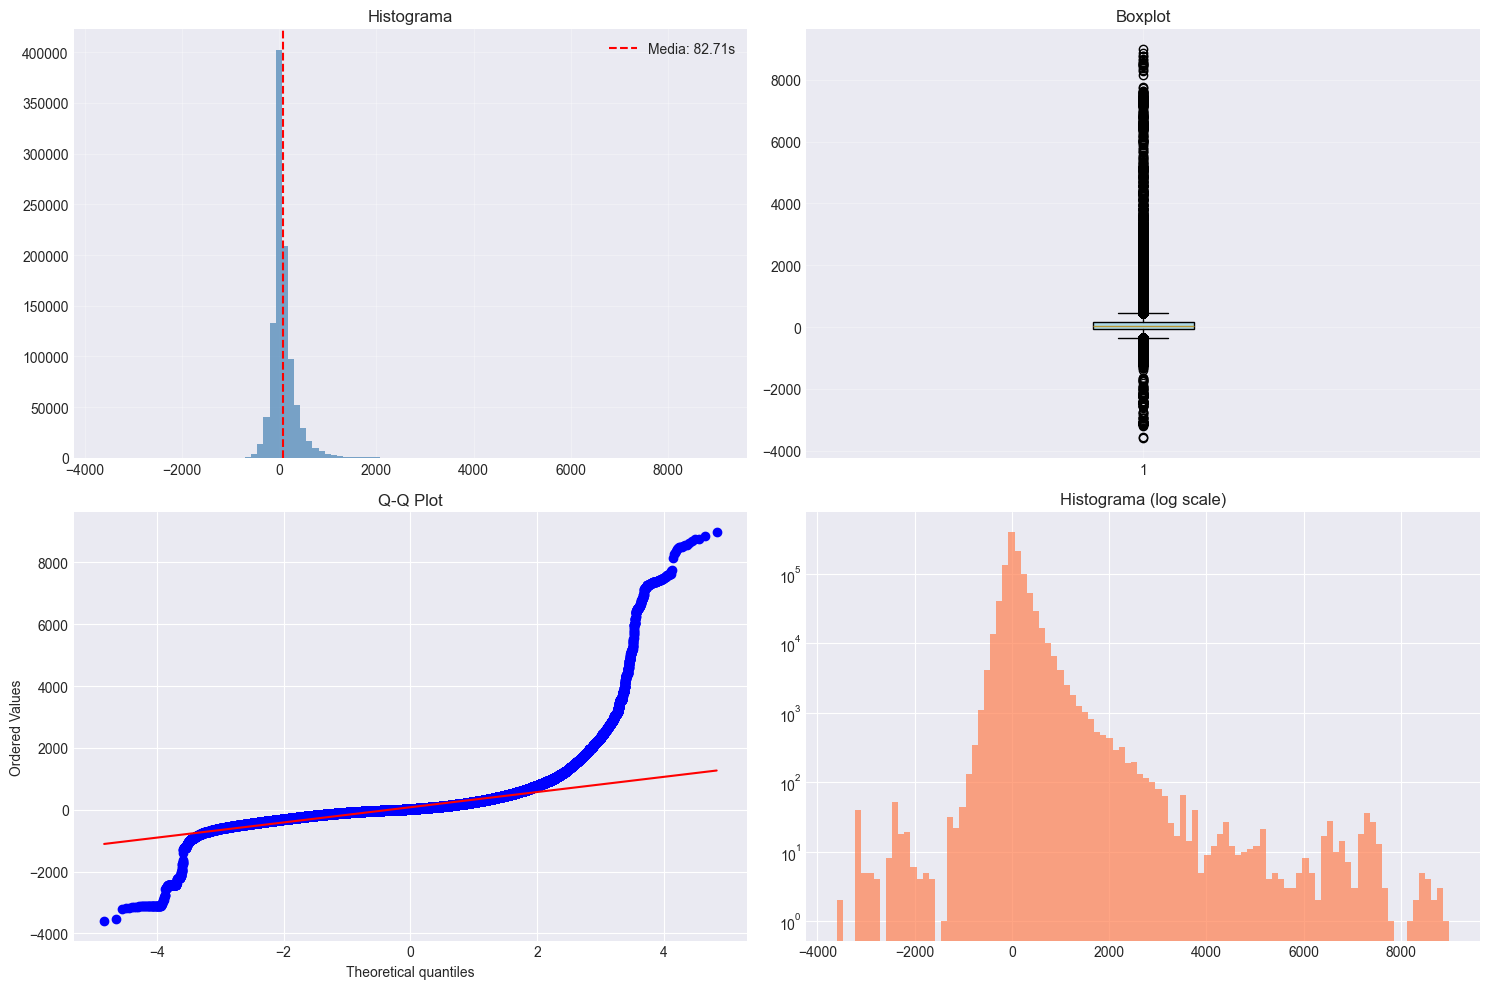

In [113]:
print("\n" + "="*70)
print("2.1 ESTADÍSTICAS DELAY_SECONDS")
print("="*70)

print(df_full['delay_seconds'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df_full['delay_seconds'].dropna(), bins=100, color='steelblue', alpha=0.7)
axes[0, 0].axvline(df_full['delay_seconds'].mean(), color='red', linestyle='--', label=f"Media: {df_full['delay_seconds'].mean():.2f}s")
axes[0, 0].set_title('Histograma')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

bp = axes[0, 1].boxplot(df_full['delay_seconds'].dropna(), patch_artist=True)
for patch in bp['boxes']: patch.set_facecolor('lightblue')
axes[0, 1].set_title('Boxplot')
axes[0, 1].grid(alpha=0.3)

from scipy import stats
stats.probplot(df_full['delay_seconds'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

axes[1, 1].hist(df_full['delay_seconds'].dropna(), bins=100, color='coral', alpha=0.7)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Histograma (log scale)')

plt.tight_layout()
plt.show()

In [114]:
# Análisis de ceros y extremos
zeros = len(df_full[df_full['delay_seconds'] == 0])
non_zeros = len(df_full[df_full['delay_seconds'] != 0])

print(f"Ceros: {zeros:,} ({zeros/len(df_full)*100:.2f}%)")
print(f"No ceros: {non_zeros:,} ({non_zeros/len(df_full)*100:.2f}%)")

percentiles = [0.90, 0.95, 0.99]
delay_nonnull = df_full['delay_seconds'].dropna()
for p in percentiles:
    val = delay_nonnull.quantile(p)
    count = len(df_full[df_full['delay_seconds'] > val])
    print(f"P{int(p*100)}: {val:.2f}s - {count:,} registros")

Ceros: 27,380 (1.97%)
No ceros: 1,363,092 (98.03%)
P90: 358.00s - 103,020 registros
P95: 535.00s - 51,501 registros
P99: 1085.00s - 10,284 registros


## Sección 3: Patrones Temporales


3.1 DELAY POR HORA
        mean  median     std  count
hour                               
0     280.83   142.0  420.20  15481
1     297.27   152.0  468.72  16512
2     274.26   127.0  429.26  17840
3     197.12    83.0  381.08  19356
4     133.41    47.0  329.04  20481
5      68.37    17.0  239.20  26044
6      91.64    28.0  310.29  37585
7      54.75     9.0  296.19  49164
8      43.97     1.0  354.96  54796
9      33.53     0.0  251.23  54883
10     57.26     9.0  295.92  53571
11     90.61    22.0  370.58  53024
12     70.25    12.0  298.54  52551
13     46.66     4.0  248.59  54255
14     44.23     5.0  236.85  54296
15     63.32    19.0  228.66  56043
16     67.88    20.0  239.81  59562
17     72.94    24.0  252.72  59322
18     72.02    22.0  253.16  57932
19     69.58    25.0  240.25  54672
20     75.44    30.0  232.57  51863
21     85.17    27.0  283.39  46850
22    100.06    37.0  278.62  38466
23    162.44    99.0  291.91  26069


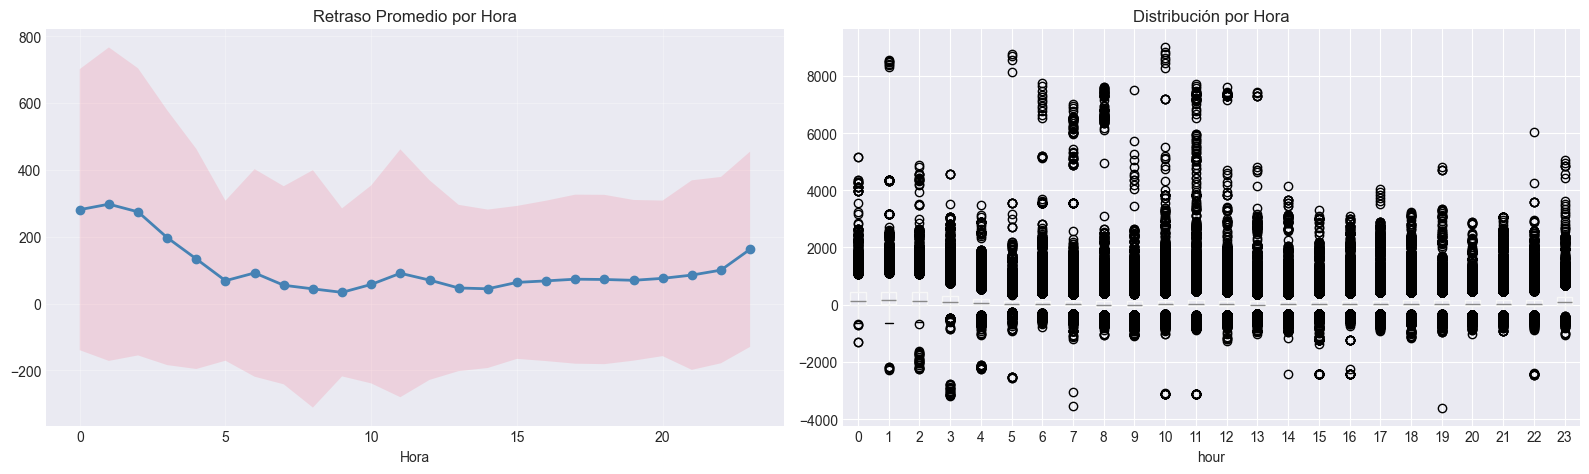

In [115]:
print("\n" + "="*70)
print("3.1 DELAY POR HORA")
print("="*70)

hourly = df_full.groupby('hour')['delay_seconds'].agg(['mean', 'median', 'std', 'count'])
print(hourly.round(2))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(hourly.index, hourly['mean'], marker='o', linewidth=2, color='steelblue')
axes[0].fill_between(hourly.index, hourly['mean'] - hourly['std'], hourly['mean'] + hourly['std'], alpha=0.2)
axes[0].set_title('Retraso Promedio por Hora')
axes[0].set_xlabel('Hora')
axes[0].grid(alpha=0.3)

df_full.boxplot(column='delay_seconds', by='hour', ax=axes[1])
axes[1].set_title('Distribución por Hora')
plt.suptitle('')

plt.tight_layout()
plt.show()


3.2 DELAY POR PERÍODO Y DÍA
                 mean   count
period_of_day                
off_peak       137.88  278962
morning_peak    52.87  196428
midday          61.92  323740
evening_peak    70.62  231488

Delay por Día:
             mean   count
dow                      
Lunes       80.81  169579
Martes      85.39  161570
Miércoles   57.74  122006
Jueves      67.10  174493
Viernes     75.49  174216
Sábado     134.67  120927
Domingo     88.59  107827


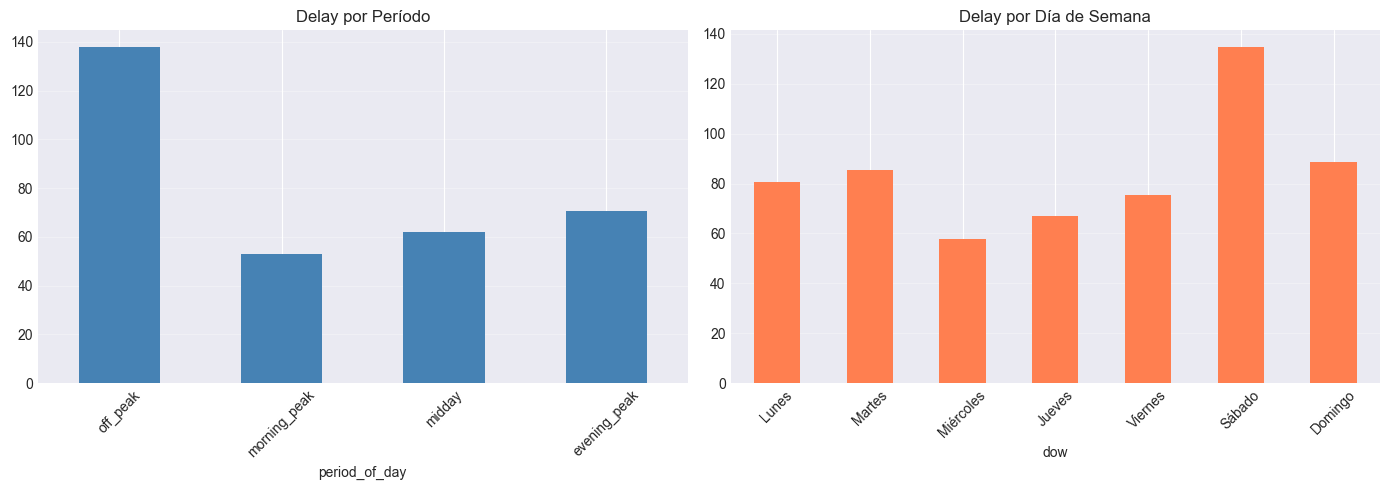

In [116]:
print("\n" + "="*70)
print("3.2 DELAY POR PERÍODO Y DÍA")
print("="*70)

period_order = ['off_peak', 'morning_peak', 'midday', 'evening_peak']
period_delay = df_full.groupby('period_of_day')['delay_seconds'].agg(['mean', 'count']).reindex(period_order)
print(period_delay.round(2))

dow_names = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
dow_delay = df_full.groupby('dow')['delay_seconds'].agg(['mean', 'count'])
dow_delay.index = dow_delay.index.map(dow_names)
print("\nDelay por Día:")
print(dow_delay.round(2))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

period_delay['mean'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Delay por Período')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y', alpha=0.3)

dow_delay['mean'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Delay por Día de Semana')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Sección 4: Análisis por Línea (Route)

In [117]:
print("\n" + "="*70)
print("4.1 DELAY POR LÍNEA (ROUTE_ID)")
print("="*70)

route_delay = df_full.groupby('route_id')['delay_seconds'].agg(['count', 'mean', 'std', 'min', 'max'])
route_delay = route_delay.sort_values('mean', ascending=False)
print(route_delay.round(2))
print(f"\nTotal líneas: {len(route_delay)}")


4.1 DELAY POR LÍNEA (ROUTE_ID)
          count    mean     std     min     max
route_id                                       
SI         4765  269.41  539.01  -473.0  6043.0
Z           994  260.91  680.82  -315.0  5437.0
B         25745  194.51  350.95 -3114.0  3142.0
C         29974  190.07  282.15  -749.0  3537.0
F         80422  185.11  394.23 -1393.0  8770.0
A         55350  164.70  414.85 -3070.0  7610.0
G         38660  149.47  206.84  -478.0  2798.0
J         48633  135.70  399.71  -930.0  7729.0
N         41918  111.95  270.17  -724.0  5501.0
E         48511   96.35  283.84  -813.0  4582.0
Q         54788   93.70  206.08 -1230.0  2205.0
FS         4828   85.93  497.74 -3600.0  7182.0
2         93438   77.65  283.68 -1058.0  3555.0
W         15770   76.19  185.28  -503.0  1825.0
D         43324   59.30  256.27 -1313.0  8542.0
H          5450   47.17  192.56  -405.0  3668.0
3         54865   39.40  256.50  -922.0  3053.0
6         76842   35.04  234.87 -2469.0  4322.0
1       

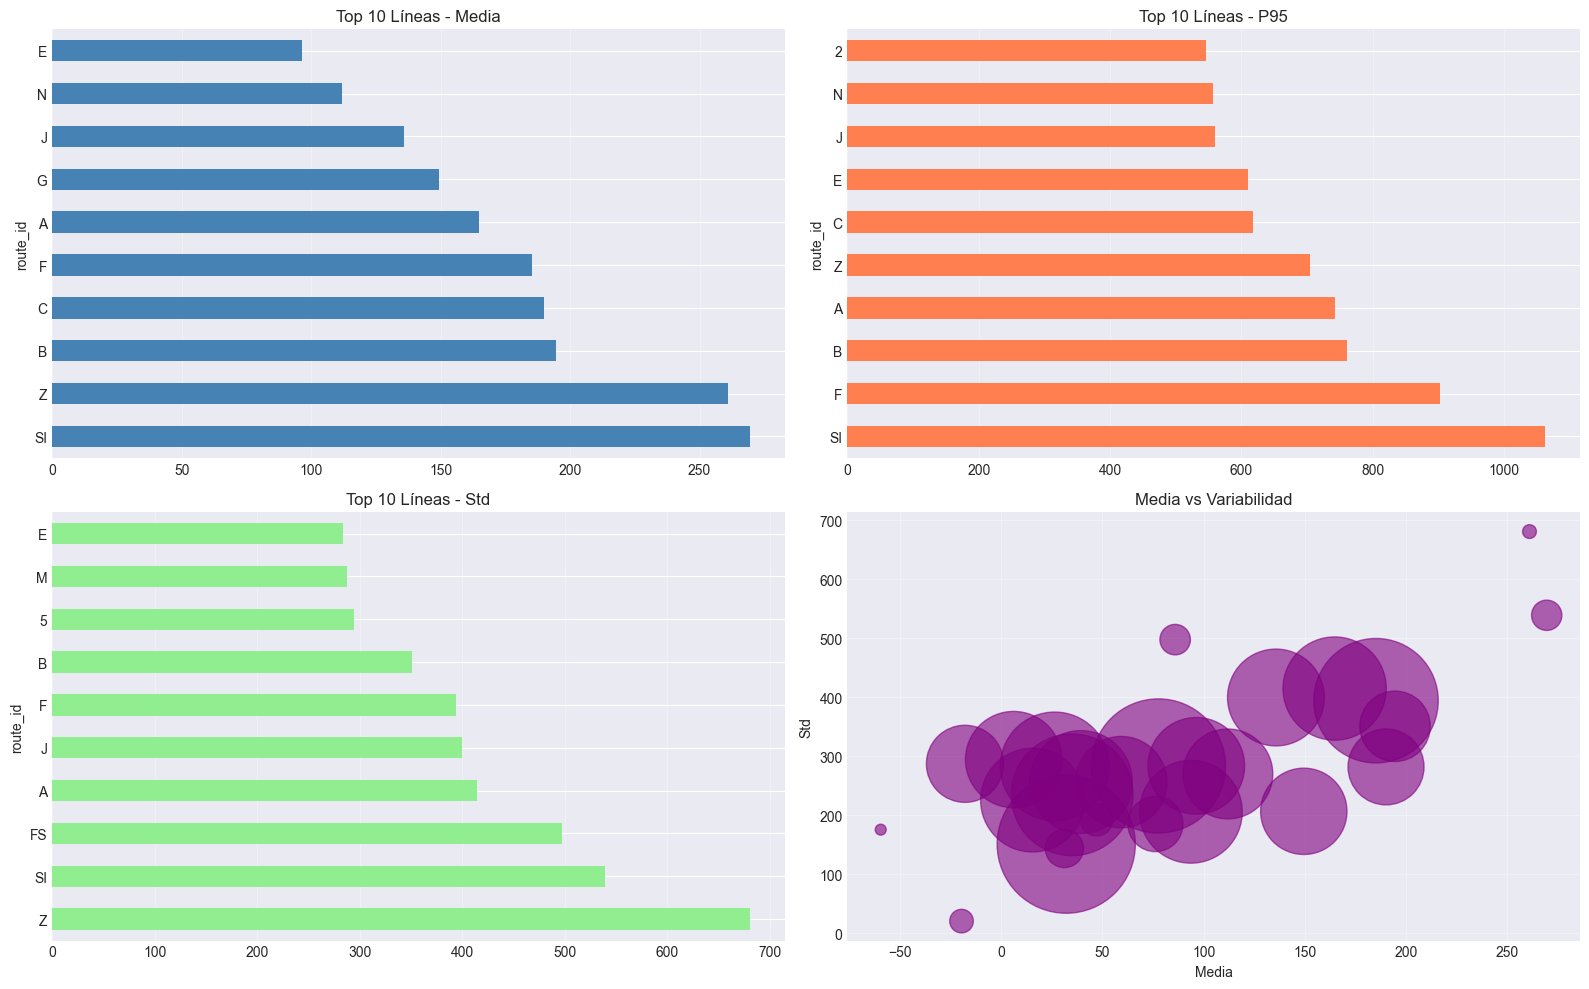

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

top10_mean = route_delay['mean'].nlargest(10)
top10_mean.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Top 10 Líneas - Media')
axes[0, 0].grid(axis='x', alpha=0.3)

route_p95 = df_full.groupby('route_id')['delay_seconds'].quantile(0.95)
route_p95.nlargest(10).plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Top 10 Líneas - P95')
axes[0, 1].grid(axis='x', alpha=0.3)

route_delay['std'].nlargest(10).plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Top 10 Líneas - Std')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].scatter(route_delay['mean'], route_delay['std'], s=route_delay['count']/10, alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Media')
axes[1, 1].set_ylabel('Std')
axes[1, 1].set_title('Media vs Variabilidad')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


4.3 INTERACCIÓN: ROUTE × HORA


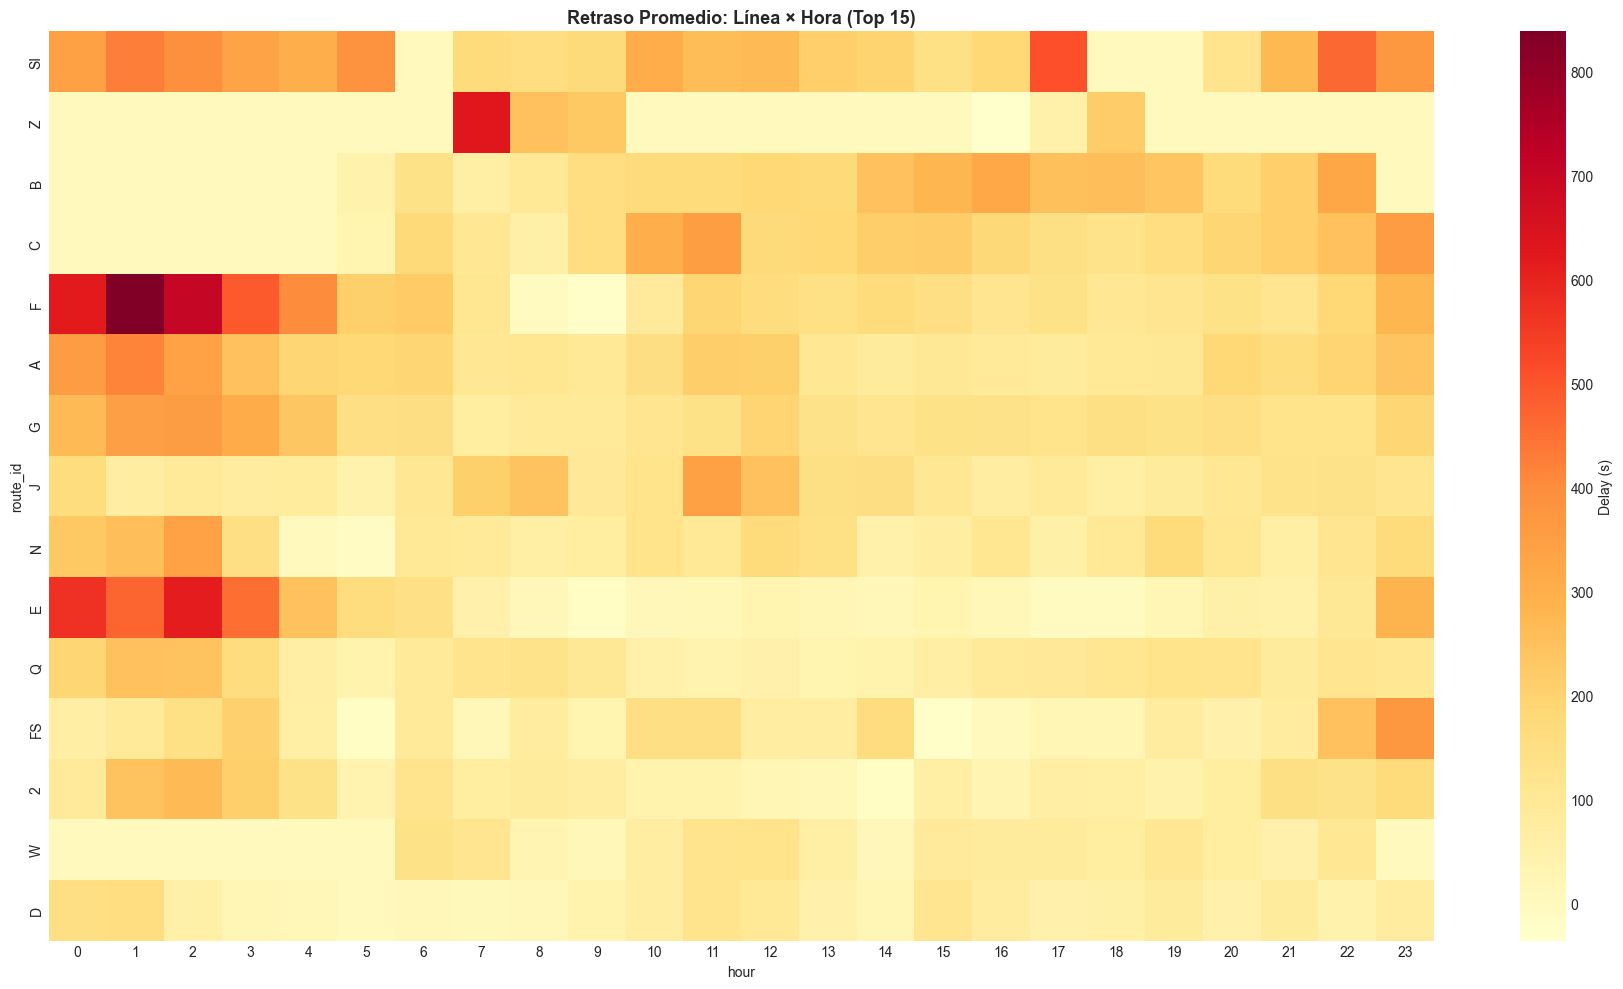


Patrones por Línea:
  SI: Max 507.6s (@17h) | Min 0.0s
  Z: Max 633.0s (@7h) | Min -36.0s
  B: Max 325.7s (@22h) | Min 0.0s
  C: Max 357.7s (@23h) | Min 0.0s
  F: Max 838.8s (@1h) | Min -23.3s


In [119]:
# 4.3 Route × Hora heatmap
print("\n" + "="*70)
print("4.3 INTERACCIÓN: ROUTE × HORA")
print("="*70)

route_hour = df_full.groupby(['route_id', 'hour'])['delay_seconds'].mean().unstack(fill_value=0)
top_routes = df_full.groupby('route_id')['delay_seconds'].mean().nlargest(15).index

fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(route_hour.loc[top_routes], cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Delay (s)'})
ax.set_title('Retraso Promedio: Línea × Hora (Top 15)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

print("\nPatrones por Línea:")
for route in list(top_routes)[:5]:
    delays = route_hour.loc[route]
    print(f"  {route}: Max {delays.max():.1f}s (@{int(delays.idxmax())}h) | Min {delays.min():.1f}s")

## Sección 5: Propagación de Retrasos


5.1 RETRASOS REZAGADOS
       delay_seconds  lagged_delay_1  lagged_delay_2
count     1030618.00      1009268.00       971332.00
mean           82.71           83.01           81.80
std           294.41          290.30          287.64
min         -3600.00        -3600.00        -3600.00
25%           -48.00          -46.00          -46.00
50%            23.00           24.00           23.00
75%           152.00          152.00          150.00
max          8996.00         8996.00         8996.00

Correlaciones:
                delay_seconds  lagged_delay_1  lagged_delay_2
delay_seconds           1.000           0.959           0.937
lagged_delay_1          0.959           1.000           0.967
lagged_delay_2          0.937           0.967           1.000


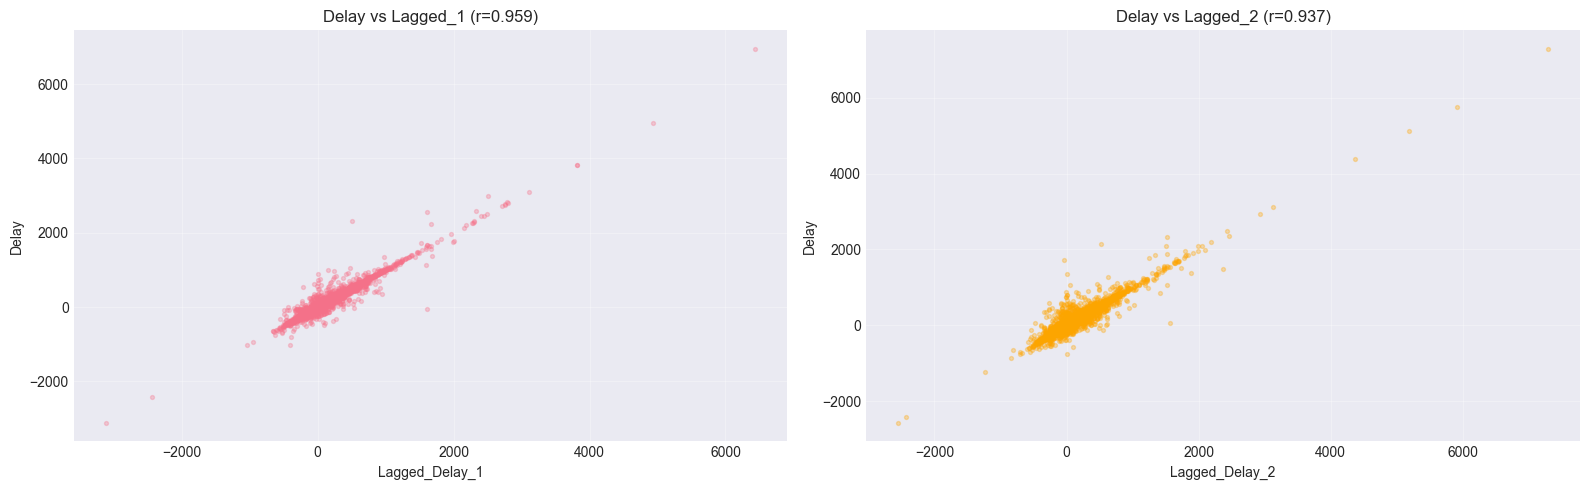

In [120]:
print("\n" + "="*70)
print("5.1 RETRASOS REZAGADOS")
print("="*70)

lagged_stats = pd.DataFrame({
    'delay_seconds': df_full['delay_seconds'].describe(),
    'lagged_delay_1': df_full['lagged_delay_1'].describe(),
    'lagged_delay_2': df_full['lagged_delay_2'].describe()
})
print(lagged_stats.round(2))

delay_cols = ['delay_seconds', 'lagged_delay_1', 'lagged_delay_2']
delay_corr = df_full[delay_cols].corr()
print("\nCorrelaciones:")
print(delay_corr.round(3))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sample = df_full.dropna(subset=['delay_seconds', 'lagged_delay_1']).sample(min(8000, len(df_full)))
axes[0].scatter(sample['lagged_delay_1'], sample['delay_seconds'], alpha=0.3, s=8)
axes[0].set_xlabel('Lagged_Delay_1')
axes[0].set_ylabel('Delay')
axes[0].set_title(f'Delay vs Lagged_1 (r={delay_corr.loc["delay_seconds", "lagged_delay_1"]:.3f})')
axes[0].grid(alpha=0.3)

sample2 = df_full.dropna(subset=['delay_seconds', 'lagged_delay_2']).sample(min(8000, len(df_full)))
axes[1].scatter(sample2['lagged_delay_2'], sample2['delay_seconds'], alpha=0.3, s=8, color='orange')
axes[1].set_xlabel('Lagged_Delay_2')
axes[1].set_ylabel('Delay')
axes[1].set_title(f'Delay vs Lagged_2 (r={delay_corr.loc["delay_seconds", "lagged_delay_2"]:.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


5.2 ROLLING DELAYS (RUTA + VIAJE)
route_rolling_delay:      0.5092
rolling_mean_delay_trip:  0.9510


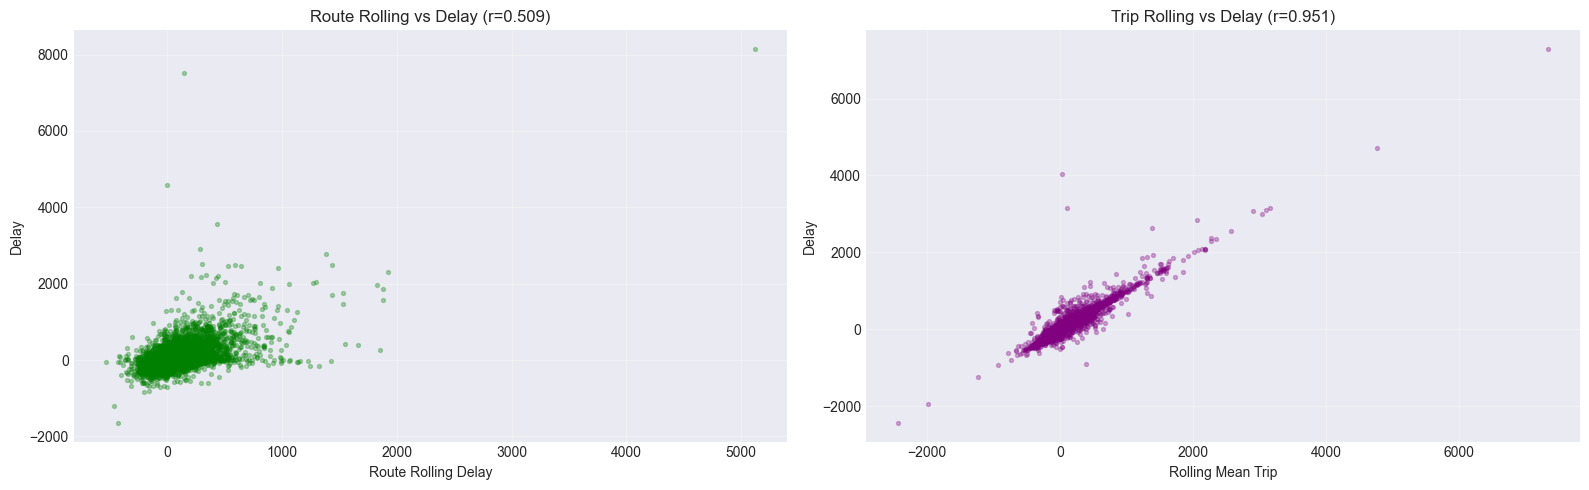

In [121]:
# 5.2 Rolling delays consolidado
print("\n" + "="*70)
print("5.2 ROLLING DELAYS (RUTA + VIAJE)")
print("="*70)

route_roll_corr = df_full['delay_seconds'].corr(df_full['route_rolling_delay'])
trip_roll_corr = df_full['delay_seconds'].corr(df_full['rolling_mean_delay_trip'])

print(f"route_rolling_delay:      {route_roll_corr:.4f}")
print(f"rolling_mean_delay_trip:  {trip_roll_corr:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sample = df_full.dropna(subset=['delay_seconds', 'route_rolling_delay']).sample(min(8000, len(df_full)))
axes[0].scatter(sample['route_rolling_delay'], sample['delay_seconds'], alpha=0.3, s=8, color='green')
axes[0].set_xlabel('Route Rolling Delay')
axes[0].set_ylabel('Delay')
axes[0].set_title(f'Route Rolling vs Delay (r={route_roll_corr:.3f})')
axes[0].grid(alpha=0.3)

sample2 = df_full.dropna(subset=['delay_seconds', 'rolling_mean_delay_trip']).sample(min(8000, len(df_full)))
axes[1].scatter(sample2['rolling_mean_delay_trip'], sample2['delay_seconds'], alpha=0.3, s=8, color='purple')
axes[1].set_xlabel('Rolling Mean Trip')
axes[1].set_ylabel('Delay')
axes[1].set_title(f'Trip Rolling vs Delay (r={trip_roll_corr:.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


5.3 MATRIZ DE CORRELACIÓN
                         delay_seconds  lagged_delay_1  lagged_delay_2  \
delay_seconds                    1.000           0.959           0.937   
lagged_delay_1                   0.959           1.000           0.967   
lagged_delay_2                   0.937           0.967           1.000   
actual_headway_seconds           0.147           0.148           0.155   
headway_ratio                    0.012           0.011           0.010   
route_rolling_delay              0.509           0.527           0.530   
rolling_mean_delay_trip          0.951           0.979           0.986   
hour                            -0.061          -0.062          -0.065   
is_peak                         -0.058          -0.058          -0.059   
dow                              0.028           0.031           0.033   
trip_progress                    0.082           0.095           0.089   

                         actual_headway_seconds  headway_ratio  \
delay_seconds     

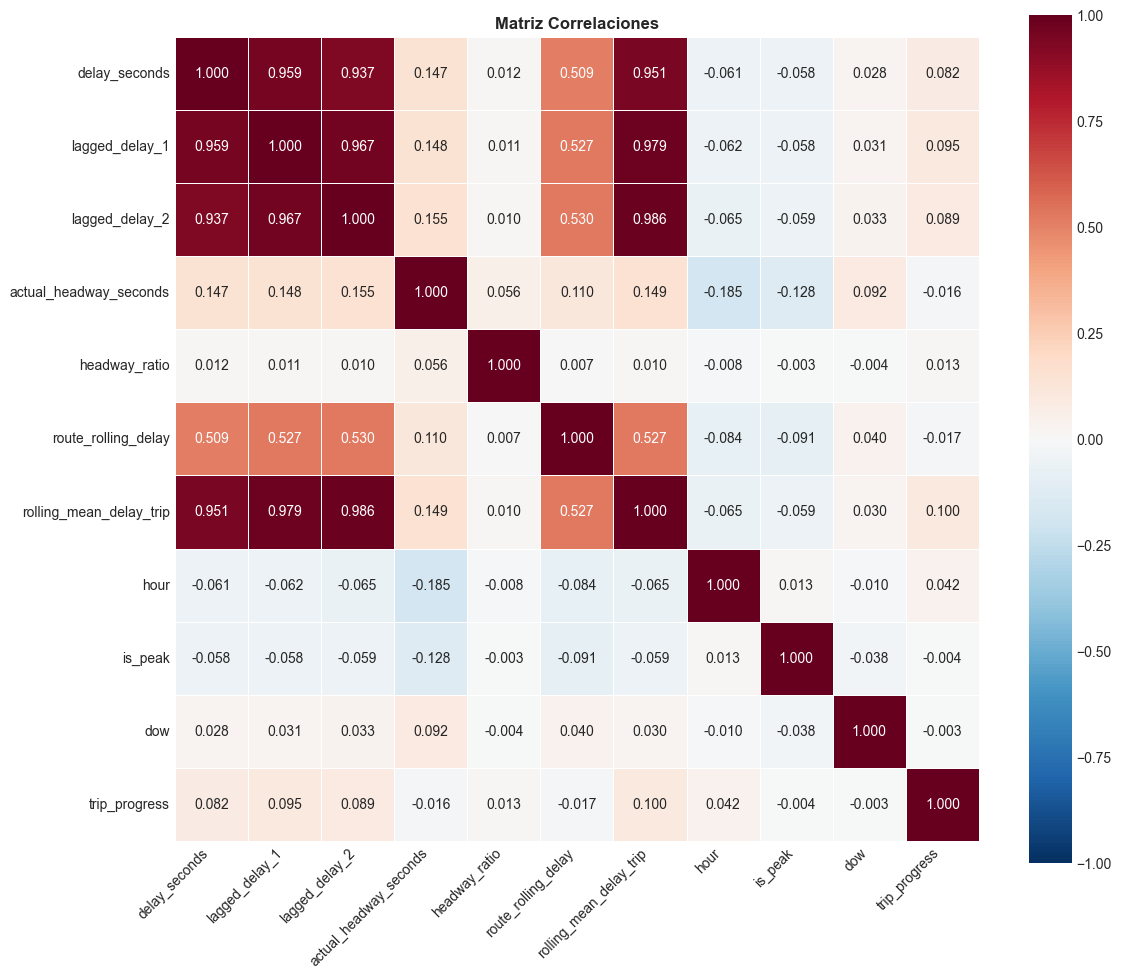

In [122]:
# Matriz de correlación
print("\n" + "="*70)
print("5.3 MATRIZ DE CORRELACIÓN")
print("="*70)

relevant_cols = [
    'delay_seconds', 'lagged_delay_1', 'lagged_delay_2',
    'actual_headway_seconds', 'headway_ratio',
    'route_rolling_delay', 'rolling_mean_delay_trip',
    'hour', 'is_peak', 'dow', 'trip_progress'
]

corr_matrix = df_full[relevant_cols].corr()
print(corr_matrix.round(3))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            square=True, ax=ax, vmin=-1, vmax=1, linewidths=0.5)
ax.set_title('Matriz Correlaciones', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Sección 6: Headway


6.1 ANÁLISIS HEADWAY
count    1367365.00
mean         427.56
std          493.21
min            0.00
25%          164.00
50%          319.00
75%          561.00
max        79008.00
Name: actual_headway_seconds, dtype: float64


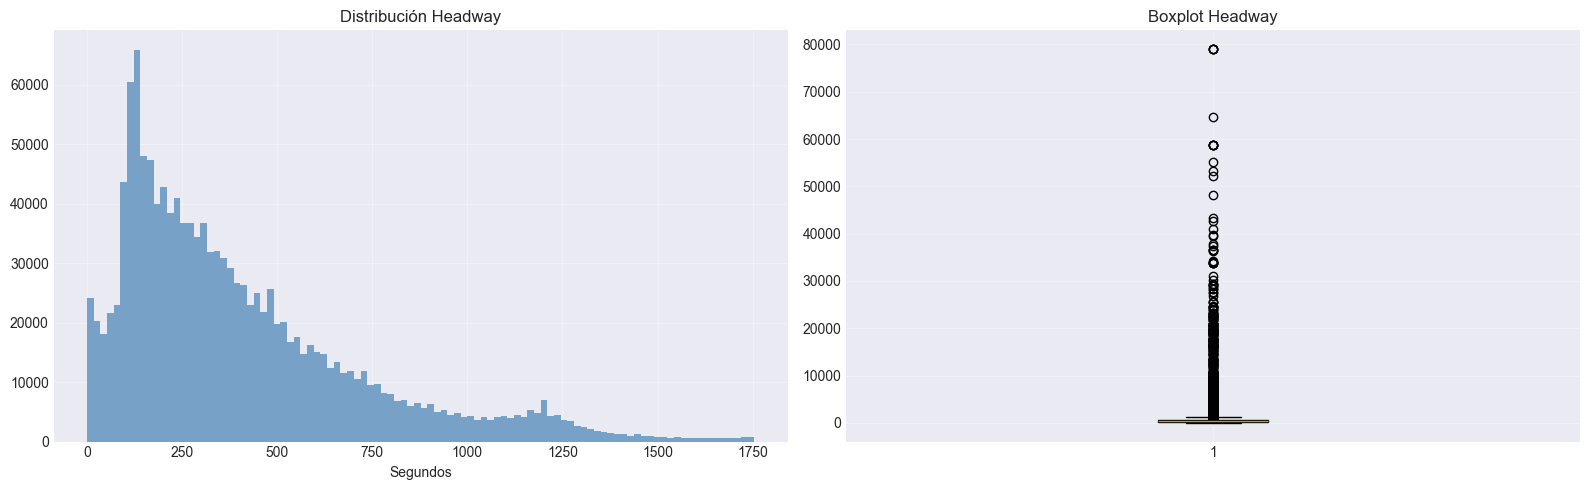

In [123]:
print("\n" + "="*70)
print("6.1 ANÁLISIS HEADWAY")
print("="*70)

print(df_full['actual_headway_seconds'].describe().round(2))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

headway_q99 = df_full['actual_headway_seconds'].quantile(0.99)
df_headway = df_full[df_full['actual_headway_seconds'] < headway_q99]

axes[0].hist(df_headway['actual_headway_seconds'].dropna(), bins=100, color='steelblue', alpha=0.7)
axes[0].set_title('Distribución Headway')
axes[0].set_xlabel('Segundos')
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot(df_full['actual_headway_seconds'].dropna(), patch_artist=True)
for patch in bp['boxes']: patch.set_facecolor('lightgreen')
axes[1].set_title('Boxplot Headway')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


6.2 HEADWAY RATIO vs DELAY

Correlación: 0.0116

Delay por decil:
          mean     std   count
decile                        
0       128.36  390.41  102233
1        81.49  312.84  102255
2        62.37  277.56  102211
3        54.54  257.43  102234
4        48.01  238.05  102238
5        55.98  223.51  102226
6        75.97  243.81  102235
7        90.99  294.54  102247
8       101.46  307.41  102217
9       117.11  338.13  102232


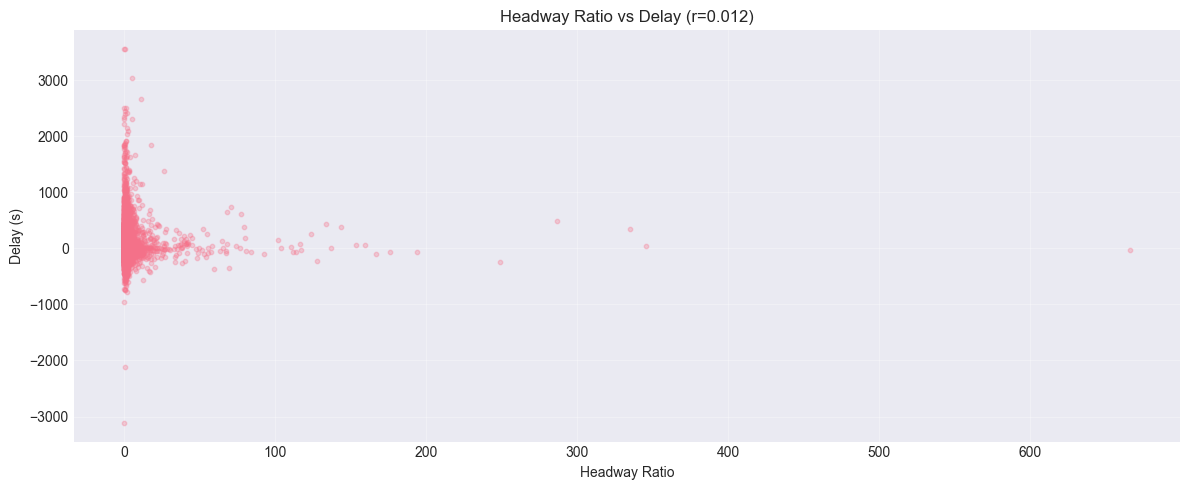

In [124]:
# 6.2 Headway ratio y delay (simplificado)
print("\n" + "="*70)
print("6.2 HEADWAY RATIO vs DELAY")
print("="*70)

headway_corr = df_full['delay_seconds'].corr(df_full['headway_ratio'])
print(f"\nCorrelación: {headway_corr:.4f}")

df_hw = df_full.dropna(subset=['delay_seconds', 'headway_ratio']).copy()
df_hw['decile'] = pd.qcut(df_hw['headway_ratio'], q=10, duplicates='drop', labels=False)
decile_stats = df_hw.groupby('decile')['delay_seconds'].agg(['mean', 'std', 'count']).round(2)
print("\nDelay por decil:")
print(decile_stats)

fig, ax = plt.subplots(figsize=(12, 5))
sample = df_hw.sample(min(10000, len(df_hw)))
ax.scatter(sample['headway_ratio'], sample['delay_seconds'], alpha=0.3, s=10)
ax.set_xlabel('Headway Ratio')
ax.set_ylabel('Delay (s)')
ax.set_title(f'Headway Ratio vs Delay (r={headway_corr:.3f})')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Sección 7: Trip Progress


7.1 TRIP PROGRESS
count     1046658.0
unique      14173.0
top             0.0
freq        38474.0
Name: trip_progress, dtype: float64

Correlación con delay: 0.0818

Delay por decil:
         count    mean     std
decile                        
0       103073   40.80  180.40
1       103130   41.39  183.88
2       103162   63.25  234.00
3       102906   70.46  249.56
4       103122   78.86  278.77
5       103049   92.41  314.16
6       103067  107.15  331.94
7       103221  125.95  353.45
8       102877  125.64  353.58
9       103004   81.25  372.03


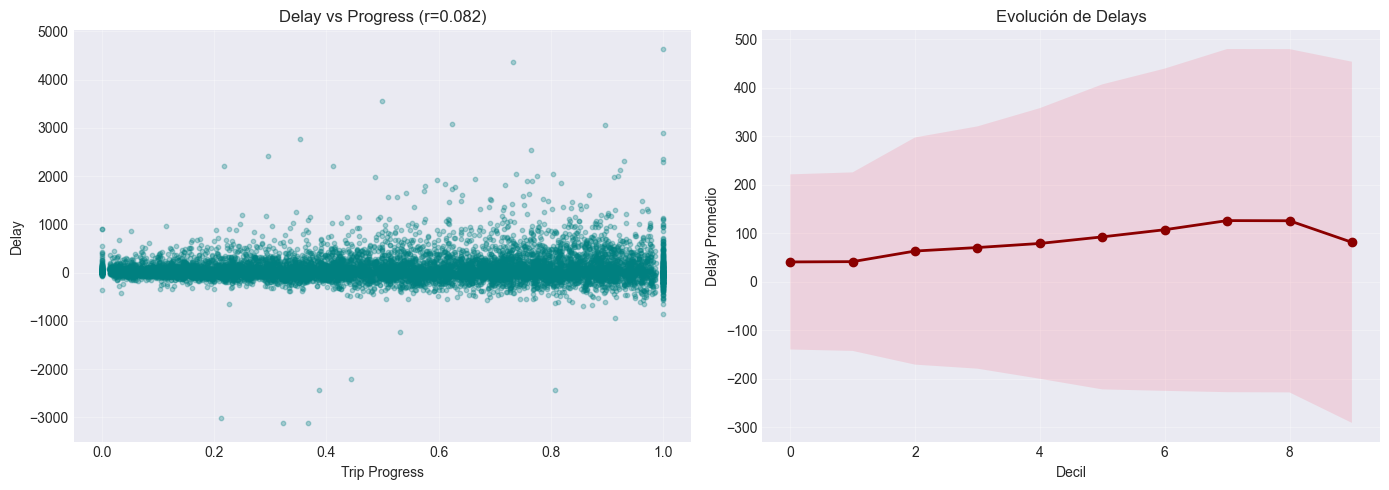

In [125]:
print("\n" + "="*70)
print("7.1 TRIP PROGRESS")
print("="*70)

print(df_full['trip_progress'].describe().round(3))
tp_corr = df_full['delay_seconds'].corr(df_full['trip_progress'])
print(f"\nCorrelación con delay: {tp_corr:.4f}")

df_tp = df_full.dropna(subset=['delay_seconds', 'trip_progress']).copy()
df_tp['decile'] = pd.qcut(df_tp['trip_progress'], q=10, duplicates='drop', labels=False)
tp_stats = df_tp.groupby('decile')['delay_seconds'].agg(['count', 'mean', 'std']).round(2)
print("\nDelay por decil:")
print(tp_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample = df_tp.sample(min(10000, len(df_tp)))
axes[0].scatter(sample['trip_progress'], sample['delay_seconds'], alpha=0.3, s=10, color='teal')
axes[0].set_xlabel('Trip Progress')
axes[0].set_ylabel('Delay')
axes[0].set_title(f'Delay vs Progress (r={tp_corr:.3f})')
axes[0].grid(alpha=0.3)

tp_mean = df_tp.groupby('decile')['delay_seconds'].mean()
axes[1].plot(tp_mean.index, tp_mean.values, marker='o', linewidth=2, color='darkred')
axes[1].fill_between(tp_mean.index, tp_mean.values - df_tp.groupby('decile')['delay_seconds'].std().values,
                      tp_mean.values + df_tp.groupby('decile')['delay_seconds'].std().values, alpha=0.2)
axes[1].set_xlabel('Decil')
axes[1].set_ylabel('Delay Promedio')
axes[1].set_title('Evolución de Delays')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Sección 7.2: Feature Importance


7.5 FEATURE IMPORTANCE (RANDOM FOREST)

Entrenando Random Forest...

Top 10 Features:
                Feature  Importance
         lagged_delay_1    0.714939
rolling_mean_delay_trip    0.265568
          trip_progress    0.011763
          route_encoded    0.004119
 actual_headway_seconds    0.001681
    route_rolling_delay    0.000933
         lagged_delay_2    0.000626
          headway_ratio    0.000176
                   hour    0.000069
                    dow    0.000061


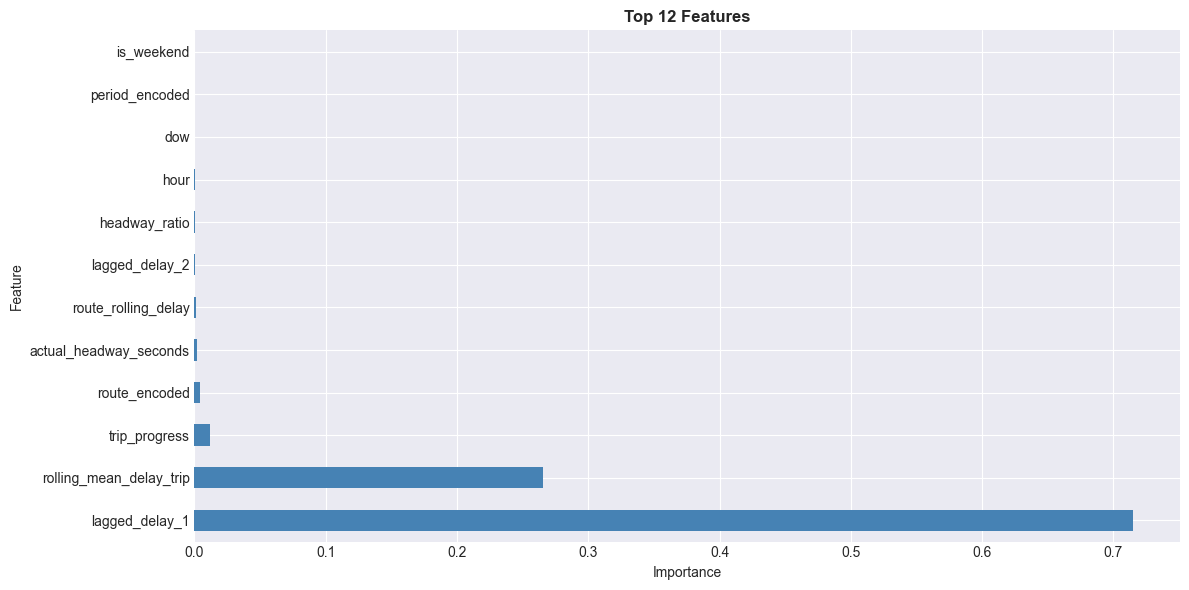


R² Score: 0.9194


In [ ]:
print("\n" + "="*70)
print("7.2 FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*70)

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

df_ml = df_full.copy()
feature_cols = ['hour', 'dow', 'is_peak', 'is_weekend',
                'lagged_delay_1', 'lagged_delay_2',
                'actual_headway_seconds', 'headway_ratio',
                'route_rolling_delay', 'rolling_mean_delay_trip', 'trip_progress']

le_route = LabelEncoder()
le_period = LabelEncoder()
df_ml['route_encoded'] = le_route.fit_transform(df_ml['route_id'].astype(str))
df_ml['period_encoded'] = le_period.fit_transform(df_ml['period_of_day'].fillna('unknown'))
feature_cols += ['route_encoded', 'period_encoded']

X = df_ml[feature_cols].fillna(0)
y = df_ml['delay_seconds'].fillna(0)

print("\nEntrenando Random Forest...")
rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X, y)

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
importance_df.head(12).plot(x='Feature', y='Importance', kind='barh', ax=ax, legend=False, color='steelblue')
ax.set_title('Top 12 Features', fontweight='bold', fontsize=12)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

r2 = rf.score(X, y)
print(f"\nR² Score: {r2:.4f}")

## Sección 8: Resumen

In [128]:
print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)

print("\n1. VARIABLE OBJETIVO:")
print(f"   Media: {df_full['delay_seconds'].mean():.2f}s")
print(f"   P95: {df_full['delay_seconds'].quantile(0.95):.2f}s")
print(f"   Distribución sesgada a derecha")

print("\n2. PATRONES TEMPORALES:")
print(f"   ✓ Variación clara por hora del día")
print(f"   ✓ Diferencias hora punta vs off-peak")
print(f"   ✓ Patrones diarios")

print("\n3. PROPAGACIÓN:")
lag1_corr = df_full['delay_seconds'].corr(df_full['lagged_delay_1'])
print(f"   Correlación t vs t-1: {lag1_corr:.4f}")

print("\n4. TOP FEATURES:")
for i in range(min(5, len(importance_df))):
    print(f"   {i+1}. {importance_df.iloc[i]['Feature']}")


RESUMEN EJECUTIVO

1. VARIABLE OBJETIVO:
   Media: 82.71s
   P95: 535.00s
   Distribución sesgada a derecha

2. PATRONES TEMPORALES:
   ✓ Variación clara por hora del día
   ✓ Diferencias hora punta vs off-peak
   ✓ Patrones diarios

3. PROPAGACIÓN:
   Correlación t vs t-1: 0.9591

4. TOP FEATURES:
   1. lagged_delay_1
   2. rolling_mean_delay_trip
   3. trip_progress
   4. route_encoded
   5. actual_headway_seconds


## Sección 8: Unscheduled Trains


9.1 UNSCHEDULED POR HORA

Porcentaje UNSCHEDULED por hora:
  00:00 - 16,781 /  32,540 =  51.57%
  01:00 - 11,234 /  27,991 =  40.13%
  02:00 -  7,766 /  25,845 =  30.05%
  03:00 -  6,282 /  25,881 =  24.27%
  04:00 -  6,034 /  26,783 =  22.53%
  05:00 -  6,712 /  33,152 =  20.25%
  06:00 - 10,201 /  48,467 =  21.05%
  07:00 - 14,731 /  64,786 =  22.74%
  08:00 - 18,583 /  74,300 =  25.01%
  09:00 - 19,641 /  75,431 =  26.04%
  10:00 - 16,378 /  70,773 =  23.14%
  11:00 - 15,829 /  69,711 =  22.71%
  12:00 - 15,516 /  68,910 =  22.52%
  13:00 - 15,012 /  70,148 =  21.40%
  14:00 - 14,794 /  69,946 =  21.15%
  15:00 - 14,969 /  71,983 =  20.80%
  16:00 - 17,051 /  77,642 =  21.96%
  17:00 - 19,585 /  79,896 =  24.51%
  18:00 - 19,197 /  78,041 =  24.60%
  19:00 - 18,097 /  73,613 =  24.58%
  20:00 - 16,618 /  69,250 =  24.00%
  21:00 - 14,298 /  61,812 =  23.13%
  22:00 - 13,065 /  52,063 =  25.09%
  23:00 - 15,433 /  41,508 =  37.18%


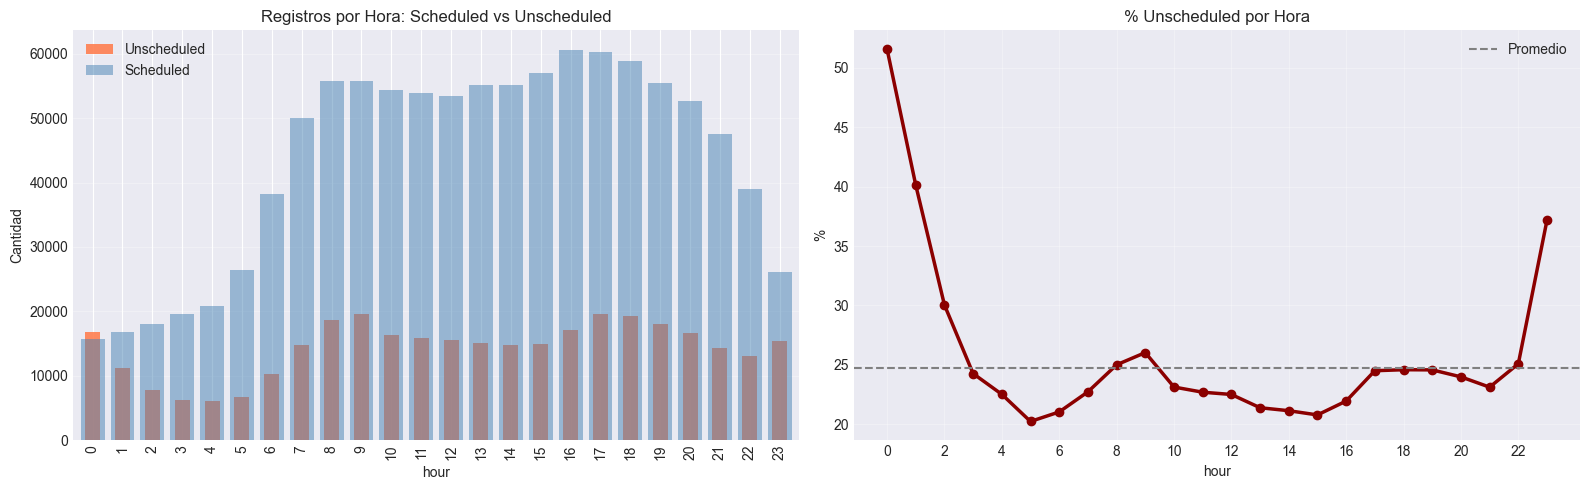

In [ ]:
print("\n" + "="*70)
print("8. UNSCHEDULED POR HORA")
print("="*70)

df_u = df_full[df_full['dataset_type'] == 'unscheduled']
df_s = df_full[df_full['dataset_type'] == 'scheduled']

unsched_h = df_u.groupby('hour').size()
sched_h = df_s.groupby('hour').size()
total_h = df_full.groupby('hour').size()
unsched_pct_h = (unsched_h / total_h * 100).fillna(0)

print(f"\nPorcentaje UNSCHEDULED por hora:")
for h in range(24):
    u_count = unsched_h.get(h, 0)
    t_count = total_h.get(h, 0)
    pct = unsched_pct_h.get(h, 0)
    print(f"  {h:02d}:00 - {u_count:>6,} / {t_count:>7,} = {pct:>6.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

unsched_h.plot(kind='bar', ax=axes[0], color='coral', alpha=0.9, label='Unscheduled')
sched_h.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.5, label='Scheduled', width=0.8)
axes[0].set_title('Registros por Hora: Scheduled vs Unscheduled')
axes[0].set_ylabel('Cantidad')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

unsched_pct_h.plot(kind='line', ax=axes[1], marker='o', linewidth=2.5, color='darkred')
axes[1].axhline(y=df_u.shape[0] / df_full.shape[0] * 100, color='gray', linestyle='--', label='Promedio')
axes[1].set_title('% Unscheduled por Hora')
axes[1].set_ylabel('%')
axes[1].set_xticks(range(0, 24, 2))
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


9.2 UNSCHEDULED POR DÍA Y RUTA

Porcentaje UNSCHEDULED por día:
  Lunes     : 61,085 / 233,408 =  26.17%
  Martes    : 66,595 / 230,792 =  28.85%
  Miércoles : 34,023 / 157,804 =  21.56%
  Jueves    : 53,008 / 230,101 =  23.04%
  Viernes   : 51,847 / 228,555 =  22.68%
  Sábado    : 36,821 / 159,730 =  23.05%
  Domingo   : 40,428 / 150,082 =  26.94%


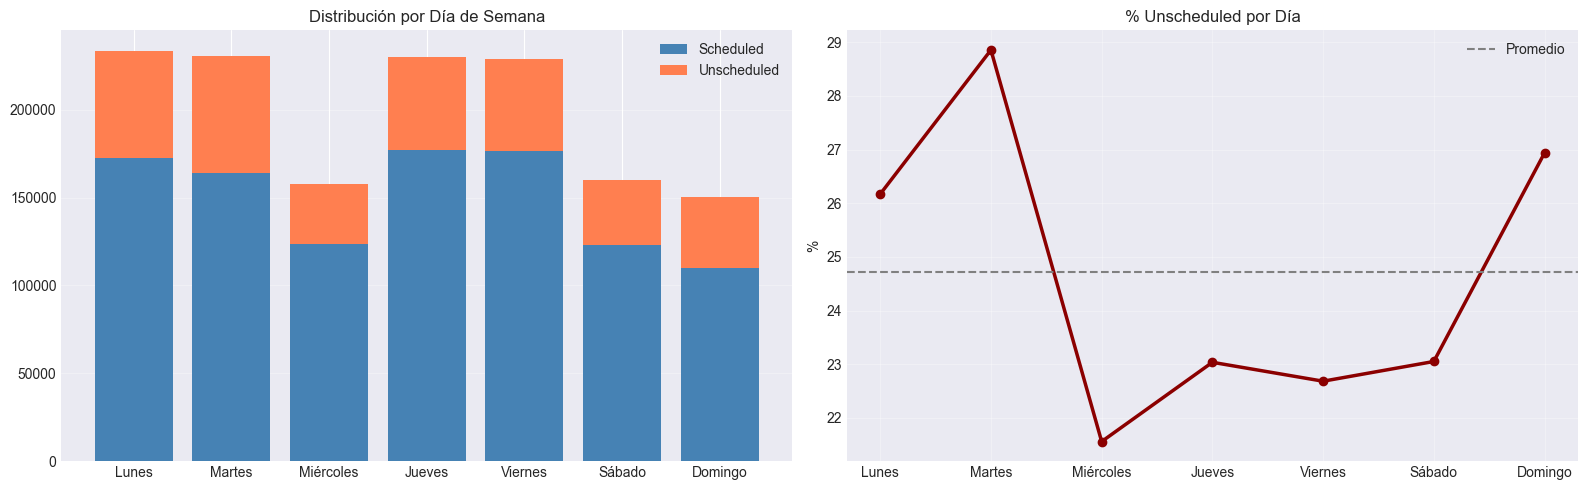


>>> Top 5 rutas con más UNSCHEDULED:

Resumen Unscheduled: 24.73% del total


In [ ]:
print("\n" + "="*70)
print("8. UNSCHEDULED POR DÍA Y RUTA")
print("="*70)

dow_names = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

unsched_d = df_u.groupby('dow').size()
sched_d = df_s.groupby('dow').size()
total_d = df_full.groupby('dow').size()
unsched_pct_d = (unsched_d / total_d * 100).fillna(0)

print(f"\nPorcentaje UNSCHEDULED por día:")
for d in range(7):
    u_count = unsched_d.get(d, 0)
    t_count = total_d.get(d, 0)
    pct = unsched_pct_d.get(d, 0)
    day = dow_names[d]
    print(f"  {day:10s}: {u_count:>6,} / {t_count:>7,} = {pct:>6.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

dow_order = [dow_names[i] for i in range(7)]
u_counts = [unsched_d.get(i, 0) for i in range(7)]
s_counts = [sched_d.get(i, 0) for i in range(7)]
x = np.arange(len(dow_order))

axes[0].bar(x, s_counts, label='Scheduled', color='steelblue')
axes[0].bar(x, u_counts, bottom=s_counts, label='Unscheduled', color='coral')
axes[0].set_title('Distribución por Día de Semana')
axes[0].set_xticks(x)
axes[0].set_xticklabels(dow_order)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

u_pct_plot = [unsched_pct_d.get(i, 0) for i in range(7)]
axes[1].plot(dow_order, u_pct_plot, marker='o', linewidth=2.5, color='darkred')
axes[1].axhline(y=df_u.shape[0] / df_full.shape[0] * 100, color='gray', linestyle='--', label='Promedio')
axes[1].set_title('% Unscheduled por Día')
axes[1].set_ylabel('%')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n>>> Top 5 rutas con más UNSCHEDULED:")
top_routes_u = df_u['route_id'].value_counts().head(5)
for route, count in top_routes_u.items():
    total = len(df_full[df_full['route_id'] == route])
    pct = count / total * 100 if total > 0 else 0
    print(f"  {route}: {count:>6,} / {total:>7,} = {pct:>6.2f}%")

print(f"\nResumen Unscheduled: {df_u.shape[0]/df_full.shape[0]*100:.2f}% del total")

## Sección 9: Predicción a Largo Plazo

### 9.1 Decaimiento de la autocorrelación
Se calcula la correlación de Pearson entre el retraso actual (`delay_seconds`) 
y distintos horizontes temporales (`delay_seconds`, `target_delay_10m`,
`target_delay_20m`, `target_delay_30m`) para visualizar cómo cae la
autocorrelación con el horizonte.

                  pearson_corr
delay_seconds         1.000000
target_delay_10m      0.867870
target_delay_20m      0.775432
target_delay_30m      0.678138


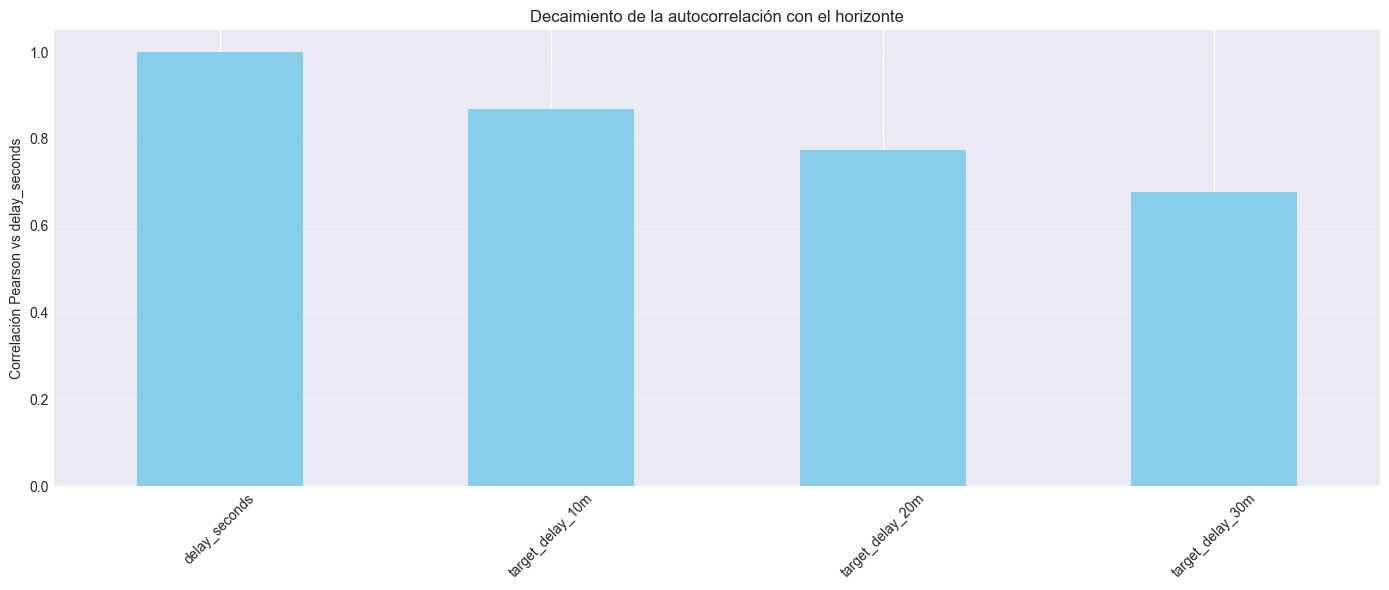

In [139]:
horizons = ['delay_seconds', 'target_delay_10m',
            'target_delay_20m', 'target_delay_30m']
corr_vals = {h: df_full['delay_seconds'].corr(df_full[h]) for h in horizons}

corr_df = pd.DataFrame.from_dict(corr_vals, orient='index',
                                 columns=['pearson_corr'])
print(corr_df)

# plot
corr_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Decaimiento de la autocorrelación con el horizonte')
plt.ylabel('Correlación Pearson vs delay_seconds')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Cambio de Importancia de Variables (Feature Shift)

Correlaciones de las entradas `lagged_delay_1`, `route_rolling_delay`,
`trip_progress` e `is_peak` frente a dos objetivos:
- corto plazo: `delay_seconds`
- largo plazo: `target_delay_30m`

                     delay_seconds  target_delay_30m
lagged_delay_1            0.959089          0.659384
route_rolling_delay       0.509207          0.431281
trip_progress             0.081837          0.053919
is_peak                  -0.057920         -0.077916


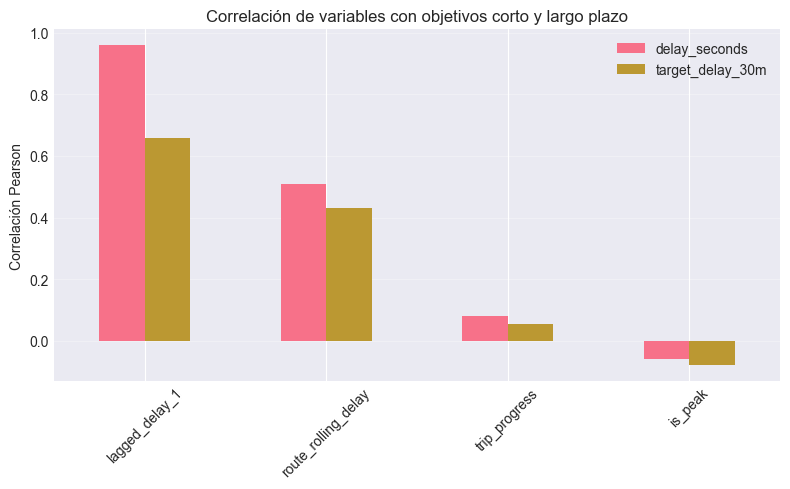

In [ ]:
# 9.2 – feature shift entre objetivos corto/largo plazo
inputs = ['lagged_delay_1', 'route_rolling_delay',
          'trip_progress', 'is_peak']
outputs = ['delay_seconds', 'target_delay_30m']

shift_df = pd.DataFrame(index=inputs, columns=outputs, dtype=float)
for inp in inputs:
    for out in outputs:
        shift_df.loc[inp, out] = df_full[inp].corr(df_full[out])

print(shift_df)

shift_df.plot(kind='bar', figsize=(8,5))
plt.title('Correlación de variables con objetivos corto y largo plazo')
plt.ylabel('Correlación Pearson')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 9.3 Análisis de Bola de Nieve por Franja Horaria

Filtramos registros con `delay_seconds` entre 120 y 300 s, agrupamos por
`period_of_day` y comparamos la media del retraso actual frente al
`target_delay_30m`. El gráfico de barras agrupadas muestra en qué periodos
los trenes recuperan o empeoran tiempo.

               delay_seconds  target_delay_30m
period_of_day                                 
evening_peak      193.692997        254.078423
midday            193.687111        256.481448
morning_peak      191.617001        217.707795
off_peak          196.875360        288.425853


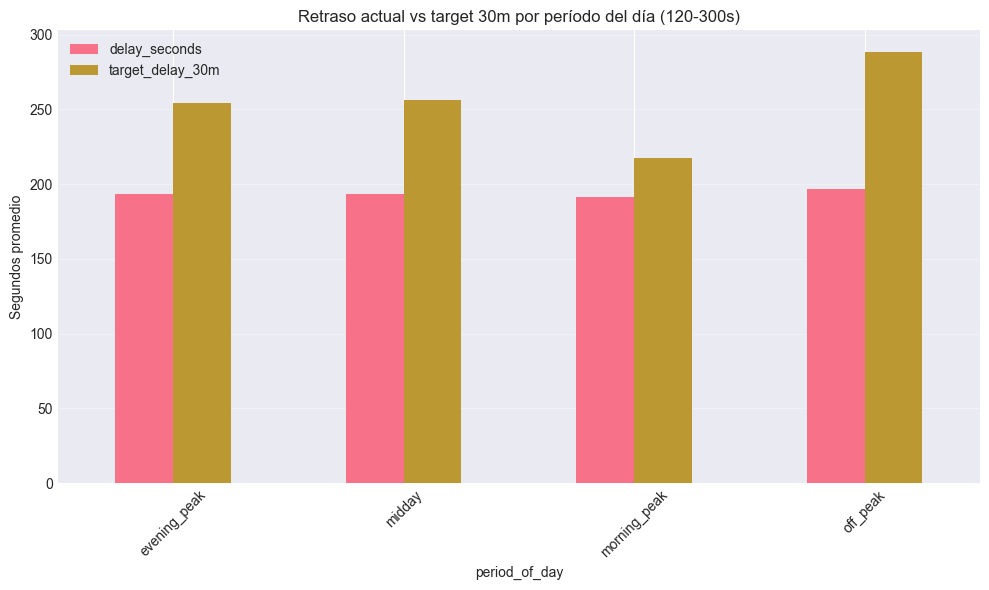

In [ ]:
# 9.3 – bola de nieve por periodo del día
subset = df_full[(df_full['delay_seconds'] >= 120) &
                 (df_full['delay_seconds'] <= 300)].copy()

period_stats = subset.groupby('period_of_day')[['delay_seconds',
                                               'target_delay_30m']].mean()
print(period_stats)

period_stats.plot(kind='bar', figsize=(10,6))
plt.title('Retraso actual vs target 30m por período del día (120-300s)')
plt.ylabel('Segundos promedio')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Sección 10: Capacidad de Recuperación

### 10.1 Delta de retraso a 30 min y salud de la línea
Se crea una columna temporal `delta_delay_30m` para medir cuánto se espera
que cambie el retraso en 30 minutos. A continuación se explora la relación
entre esta cantidad y el `route_rolling_delay` (salud de la línea) y se
calcula la media por franja horaria.

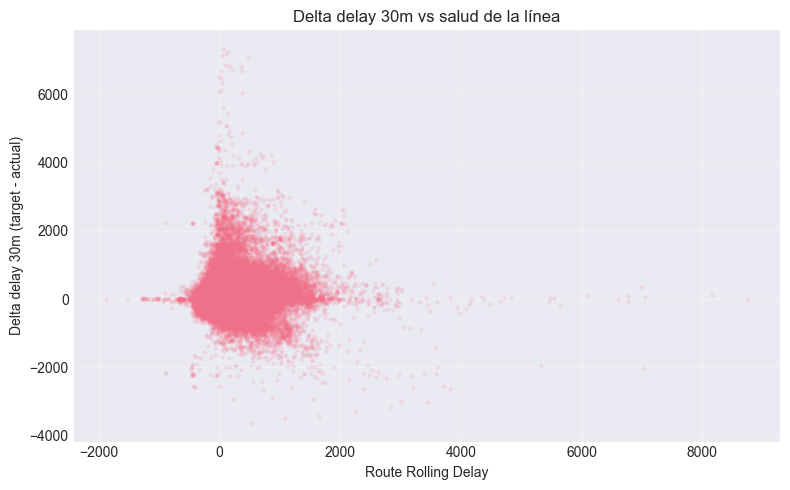

Media delta_delay_30m por periodo:
period_of_day
evening_peak    46.129787
midday          41.537944
morning_peak    22.731557
off_peak        69.469370
Name: delta_delay_30m, dtype: float64


In [142]:
# 10.1 – delta y scatter
# 1. crear columna temporal (filtrando NaNs en target_delay_30m)
df_temp = df_full.dropna(subset=['target_delay_30m']).copy()
df_temp['delta_delay_30m'] = df_temp['target_delay_30m'] - df_temp['delay_seconds']

# scatter con alpha bajo
plt.figure(figsize=(8,5))
plt.scatter(df_temp['route_rolling_delay'], df_temp['delta_delay_30m'],
            alpha=0.1, s=5)
plt.xlabel('Route Rolling Delay')
plt.ylabel('Delta delay 30m (target - actual)')
plt.title('Delta delay 30m vs salud de la línea')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# media de delta por periodo
delta_period = df_temp.groupby('period_of_day')['delta_delay_30m'].mean()
print("Media delta_delay_30m por periodo:")
print(delta_period)

### 10.2 Líneas que absorben mejor los retrasos
Nos quedamos con trenes que ya tienen un retraso importante
(`delay_seconds > 180`) y calculamos la media de `target_delay_end` por
`route_id`. Un gráfico de barras horizontal ordenado muestra qué líneas
terminan más retrasadas y cuáles reducen el retraso.

route_id
FX   -169.400000
F     206.108687
R     264.252877
W     270.198517
M     277.970366
Name: target_delay_end, dtype: float64


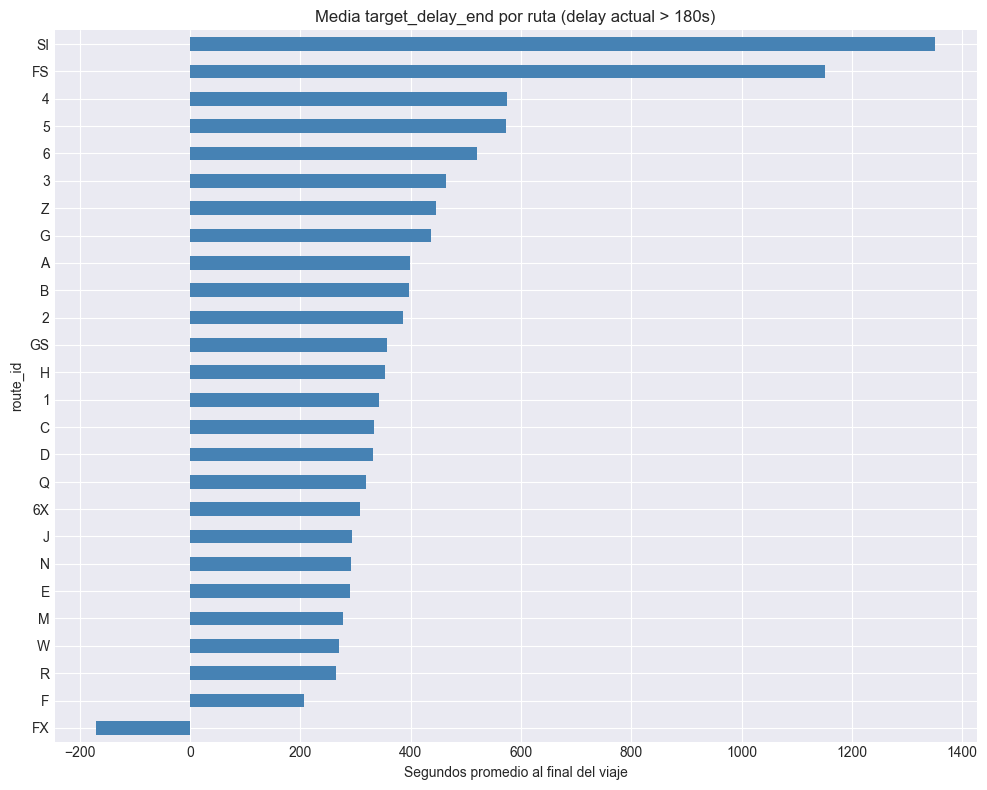

In [143]:
# 10.2 – retraso final por línea para trenes retrasados actualmente
late = df_full[df_full['delay_seconds'] > 180].copy()
route_end = late.groupby('route_id')['target_delay_end'].mean().sort_values()
print(route_end.head())  # mostrar primeras líneas como sanity check

# grafico horizontal
plt.figure(figsize=(10,8))
route_end.plot(kind='barh', color='steelblue')
plt.title('Media target_delay_end por ruta (delay actual > 180s)')
plt.xlabel('Segundos promedio al final del viaje')
plt.ylabel('route_id')
plt.tight_layout()
plt.show()

### 10.3 Impacto de la distancia en el retraso final
Agrupamos por `stops_to_end` y calculamos la mediana y el percentil 90 de
`target_delay_end`. Dos líneas superpuestas permiten ver cómo varían la
mediana y el P90 a medida que nos acercamos al destino.

              mediana    p90
stops_to_end                
0                -2.0  396.0
1                -2.0  396.0
2                 0.0  420.0
3                 0.0  420.0
4                 3.0  423.0


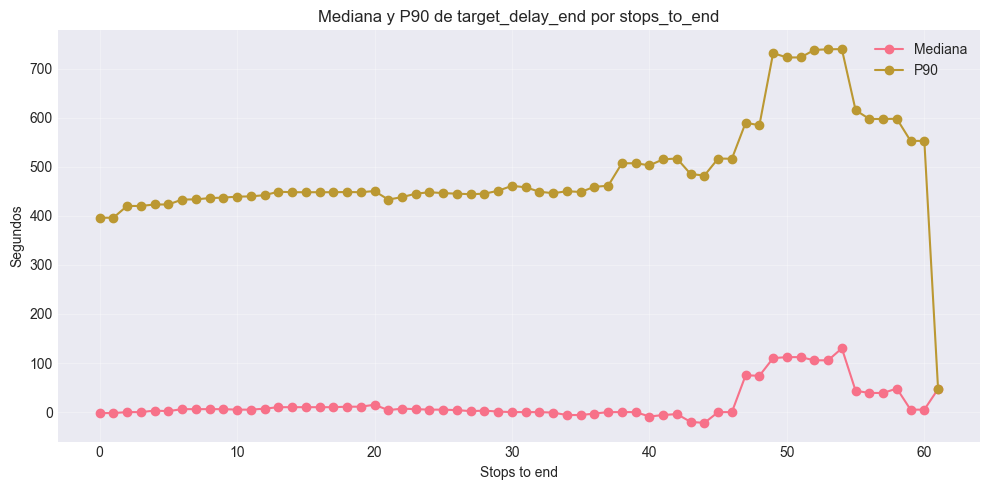

In [144]:
# 10.3 – bivariado distance vs retraso final
agg = df_full.groupby('stops_to_end')['target_delay_end'].agg(
    mediana='median', p90=lambda x: x.quantile(0.90)
)
print(agg.head())

plt.figure(figsize=(10,5))
plt.plot(agg.index, agg['mediana'], label='Mediana', marker='o')
plt.plot(agg.index, agg['p90'], label='P90', marker='o')
plt.title('Mediana y P90 de target_delay_end por stops_to_end')
plt.xlabel('Stops to end')
plt.ylabel('Segundos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 10.4 Importancia de características empírica para 30 min
Se entrena un RandomForestRegressor ligero para predecir
`target_delay_30m` y se visualizan las importancias de las variables
seleccionadas.

In [148]:
from sklearn.ensemble import RandomForestRegressor

# preparar subset sin NaNs en los objetivos
ml = df_temp.dropna(subset=['delta_delay_30m']).copy()

# Features de entorno y estado base
features = ['delay_seconds', 'route_rolling_delay', 
            'actual_headway_seconds', 'is_peak', 'hour']
X = ml[features].fillna(0)

# predecimos el cambio, no el valor absoluto
y = ml['delta_delay_30m'] 

rf = RandomForestRegressor(n_estimators=20, max_depth=5,
                           random_state=42, n_jobs=-1)
rf.fit(X, y)

imp = pd.DataFrame({'feature': features,
        'importance': rf.feature_importances_}).sort_values('importance', ascending=True)

print(imp)

                  feature  importance
3                 is_peak    0.000000
2  actual_headway_seconds    0.026987
4                    hour    0.144017
0           delay_seconds    0.280880
1     route_rolling_delay    0.548116
